<a href="https://colab.research.google.com/github/KillerStrike17/EVA-5/blob/master/5.%20Code%20Drill/EVA5_Code_Drill_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is Version 3 of the code drill

The main focus here is to get 99.4% accuracy in less than 10k parameters in less than 15 Epochs

## Importing Libraries



In [1]:
import torch 
import torch.nn as nn # All NN Layers
import torch.nn.functional as F # to get loss fucnction
import torch.optim as optim # Optimizer Fucntion
from torchvision import datasets, transforms #Loading Dataset and transform function to perform transformation
from torchsummary import summary # To view summary
%matplotlib inline
import matplotlib.pyplot as plt # To plot graphs
from torch.optim.lr_scheduler import StepLR,OneCycleLR, ReduceLROnPlateau
from tqdm import tqdm


## Data Transformation

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [13]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(fill=(0,),degrees=(-5,5)), # Randomly rotating 50& of the image in the range -5,5
                                       transforms.ToTensor(), # Converting to Tensor
                                       transforms.Normalize((0.1307,),(0.3081,)) # Normalizing the dataset with the mean and std 
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Converting to Tensor
                                    transforms.Normalize((0.1307,),(0.3081,))  # Normalizing the dataset using mean and std
                                  ])

## Dataset Cleaning and Train/Test Split

In [14]:
train = datasets.MNIST('./data',train= True,download= True, transform = train_transforms) # Downloading Train set
test = datasets.MNIST('./data',train= False,download= True, transform = test_transforms) # Downloading Test set

## CONSTANTS

In [15]:
SEED = 1
BATCHSIZE = 128
BATCHSIZE_2 = 64
NUM_OF_WORKER = 4
DROPOUT_VALUE = 0
EPOCHS = 15

## Data Loading

In [16]:
# Checking for CUDA
cuda = torch.cuda.is_available()
print("CUDA Available",cuda)

torch.manual_seed(SEED)
if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args= dict(shuffle = True, batch_size = BATCHSIZE, num_workers = NUM_OF_WORKER,pin_memory = True) if cuda else dict(shuffle = True, batch_size  = BATCHSIZE_2)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args) # creating train data loader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args) # creating test dataloader

CUDA Available True


## The Model

In [35]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(9),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=9,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(18),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Transition Block 1
    self.transitionblock1 = nn.Sequential(
        nn.Conv2d(in_channels = 18,out_channels = 12,kernel_size = (1,1),padding = 0,bias = False),
        nn.MaxPool2d(2,2)
    )

    # Convolution Block 3
    self.convblock3= nn.Sequential(
        nn.Conv2d(in_channels=12,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(18),
        nn.Dropout(DROPOUT_VALUE)
    )

    # Convolution Block 4
    self.convblock4= nn.Sequential(
        nn.Conv2d(in_channels=18,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(18),
        nn.Dropout(DROPOUT_VALUE)
    )

    self.convblock5= nn.Sequential(
        nn.Conv2d(in_channels=18,out_channels=18,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
        nn.BatchNorm2d(18),
        nn.Dropout(DROPOUT_VALUE)
    )

    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=5),
        nn.Conv2d(in_channels=18,out_channels=10,kernel_size=(1,1),padding = 0, bias = True)
    )
  
  def forward(self, x):
    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.transitionblock1(x)
    x = self.convblock3(x)
    x = self.convblock4(x)
    x = self.convblock5(x)
    x = self.gap(x)
    x = x.view(-1,10)
    return F.log_softmax(x,dim = -1)



## Model Parameters
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [36]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 26, 26]              81
              ReLU-2            [-1, 9, 26, 26]               0
       BatchNorm2d-3            [-1, 9, 26, 26]              18
           Dropout-4            [-1, 9, 26, 26]               0
            Conv2d-5           [-1, 18, 24, 24]           1,458
              ReLU-6           [-1, 18, 24, 24]               0
       BatchNorm2d-7           [-1, 18, 24, 24]              36
           Dropout-8           [-1, 18, 24, 24]               0
            Conv2d-9           [-1, 12, 24, 24]             216
        MaxPool2d-10           [-1, 12, 12, 12]               0
           Conv2d-11           [-1, 18, 10, 10]           1,944
             ReLU-12           [-1, 18, 10, 10]               0
      BatchNorm2d-13           [-1, 18, 10, 10]              36
          Dropout-14           [-1, 18,

In [37]:


train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [38]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10810038447380066 Batch_id=468 Accuracy=91.00: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0697, Accuracy: 9819/10000 (98.19%)

EPOCH: 1


Loss=0.07035060971975327 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9840/10000 (98.40%)

EPOCH: 2


Loss=0.028127489611506462 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 34.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9909/10000 (99.09%)

EPOCH: 3


Loss=0.04770689085125923 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:13<00:00, 35.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0508, Accuracy: 9844/10000 (98.44%)

EPOCH: 4


Loss=0.05852309241890907 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:13<00:00, 35.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.018124569207429886 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 36.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.01613711565732956 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:12<00:00, 37.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9941/10000 (99.41%)

EPOCH: 7


Loss=0.030178198590874672 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 36.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9942/10000 (99.42%)

EPOCH: 8


Loss=0.02578783594071865 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.006339129060506821 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9939/10000 (99.39%)

EPOCH: 10


Loss=0.0452033132314682 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 11


Loss=0.03297131136059761 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:13<00:00, 35.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

EPOCH: 12


Loss=0.00629989430308342 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:13<00:00, 35.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9947/10000 (99.47%)

EPOCH: 13


Loss=0.004938262049108744 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:13<00:00, 36.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 14


Loss=0.006252367049455643 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:12<00:00, 37.04it/s]



Test set: Average loss: 0.0195, Accuracy: 9947/10000 (99.47%)



Text(0.5, 1.0, 'Test Accuracy')

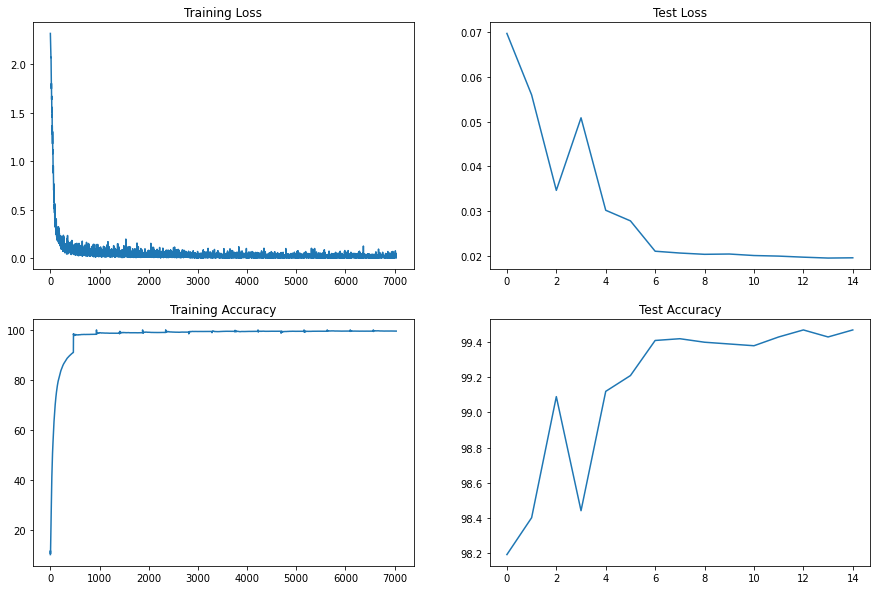

In [39]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [40]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09604013711214066 Batch_id=468 Accuracy=91.65: 100%|██████████| 469/469 [00:13<00:00, 35.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0830, Accuracy: 9776/10000 (97.76%)

EPOCH: 1


Loss=0.10013142228126526 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9844/10000 (98.44%)

EPOCH: 2


Loss=0.053568173199892044 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9879/10000 (98.79%)

EPOCH: 3


Loss=0.019159549847245216 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.012517359107732773 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.04259727522730827 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 36.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9897/10000 (98.97%)

EPOCH: 6


Loss=0.015477520413696766 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.046554889529943466 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.0030225366353988647 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9916/10000 (99.16%)

EPOCH: 9


Loss=0.006371961906552315 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:13<00:00, 35.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9903/10000 (99.03%)

EPOCH: 10


Loss=0.020063064992427826 Batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:13<00:00, 35.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.005689261015504599 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:12<00:00, 37.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9931/10000 (99.31%)

EPOCH: 12


Loss=0.016896001994609833 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:12<00:00, 37.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.015820756554603577 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:12<00:00, 36.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.0047417194582521915 Batch_id=468 Accuracy=99.66: 100%|██████████| 469/469 [00:12<00:00, 36.30it/s]



Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)



Text(0.5, 1.0, 'Test Accuracy')

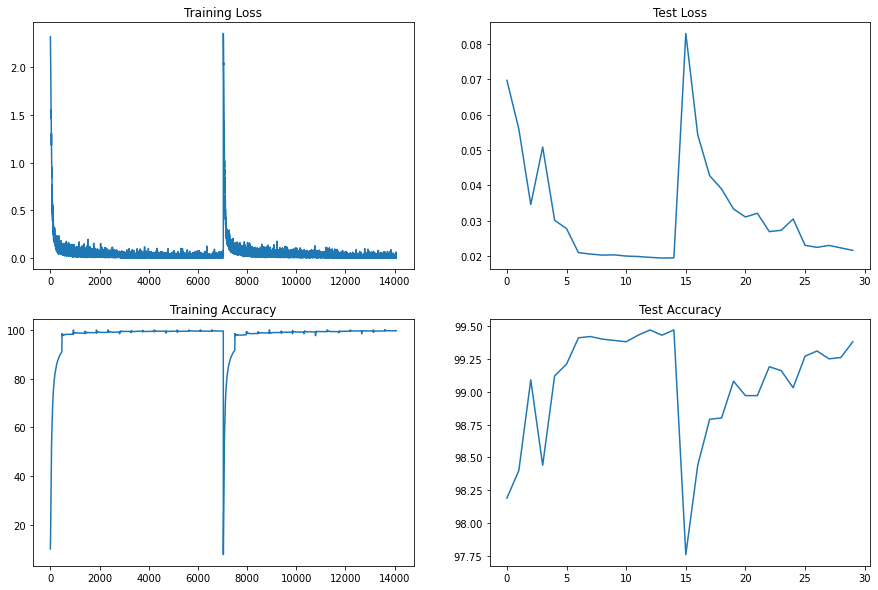

In [41]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [42]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.052886802703142166 Batch_id=468 Accuracy=90.81: 100%|██████████| 469/469 [00:12<00:00, 36.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0943, Accuracy: 9742/10000 (97.42%)

EPOCH: 1


Loss=0.04994146525859833 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:13<00:00, 35.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.05249190330505371 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:12<00:00, 37.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9906/10000 (99.06%)

EPOCH: 3


Loss=0.0114999795332551 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 37.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.03306596353650093 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:12<00:00, 37.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.025730395689606667 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.020908942446112633 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:12<00:00, 37.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.01999237760901451 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9918/10000 (99.18%)

EPOCH: 8


Loss=0.018993256613612175 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:12<00:00, 36.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

EPOCH: 9


Loss=0.010070372372865677 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:12<00:00, 37.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.0060281758196651936 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:12<00:00, 36.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.0034715046640485525 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:12<00:00, 36.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9941/10000 (99.41%)

EPOCH: 12


Loss=0.02057036943733692 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:12<00:00, 37.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.024041183292865753 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:12<00:00, 37.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.004421543329954147 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:12<00:00, 37.03it/s]



Test set: Average loss: 0.0206, Accuracy: 9939/10000 (99.39%)



Text(0.5, 1.0, 'Test Accuracy')

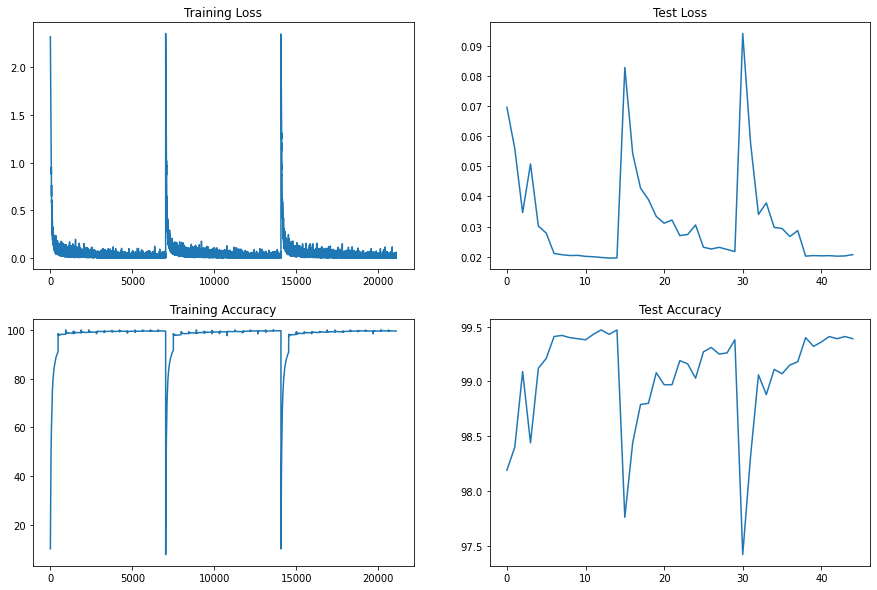

In [43]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")